! uv pip install jax[cuda12] --force-reinstall
# Imports

In [1]:
import mmml
import ase
import os
from pathlib import Path
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".85"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [2]:
from mmml.physnetjax import *

In [3]:
from mmml.physnetjax.physnetjax.calc.helper_mlp import get_ase_calc
reshifted = False

In [4]:
from mmml.physnetjax.physnetjax.models import model as model
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model


# Data

In [5]:
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit

In [6]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)
BATCHSIZE = 8

In [7]:
# Initialize random key for data loading
if 'data_key' not in globals():
    data_key = jax.random.PRNGKey(42)


data_file = "/pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz"

print(f"Loading data from: {data_file}")

# Prepare datasets
train_data, valid_data = prepare_datasets(
    data_key, 
    10500,  # num_train
    10500,  # num_valid
    [data_file], 
    natoms=20
)


Loading data from: /pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz
dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [8]:
files = [data_file]
train_size = 20000 
valid_size = 1000
NATOMSMAX = 20

train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=NATOMSMAX)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [9]:
import openqdc

In [10]:
train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=NATOMSMAX)



valid_batches = prepare_batches_jit(data_key, valid_data, BATCHSIZE, num_atoms = NATOMSMAX)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [11]:
atom_energies = {1: -13.717939590030356 ,
6: -1029.831662730747 ,
7: -1485.40806126101 ,
8: -2042.7920344362644 ,
16: -10831.264715514206 ,}

In [12]:
XXX = train_data["E"] / (train_data["Z"].sum(axis=1))
XXX .flatten().flatten().mean()

np.float64(-1.3306833009327976)

## Save Checkpoint as JSON (for portability)

After training, you can save checkpoints as JSON files for easy loading without requiring orbax or pickle. This is useful for sharing models or loading in different environments.


In [13]:
# ========================================================================
# SAVE CHECKPOINT AS JSON (no orbax/pickle required for loading)
# ========================================================================
# This function converts JAX parameters to JSON-serializable format
# and saves them along with model configuration

def save_checkpoint_as_json(params, model, save_dir, epoch=None, best_loss=None):
    """
    Save model checkpoint as JSON files for portability.
    
    This saves:
    - params.json: Model parameters (converted from JAX arrays to lists)
    - model_config.json: Model configuration
    
    Args:
        params: Model parameters (JAX PyTree)
        model: Model instance
        save_dir: Directory to save checkpoint files
        epoch: Optional epoch number
        best_loss: Optional best loss value
    """
    import json
    from pathlib import Path
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Helper function to convert JAX arrays to JSON-serializable format
    def jax_to_json(obj):
        """Recursively convert JAX arrays to lists for JSON serialization."""
        if isinstance(obj, dict):
            return {k: jax_to_json(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [jax_to_json(item) for item in obj]
        elif hasattr(obj, '__array__'):  # JAX/NumPy arrays
            return jnp.asarray(obj).tolist()
        elif isinstance(obj, (int, float, str, bool, type(None))):
            return obj
        else:
            # Try to convert to array if possible
            try:
                return jnp.asarray(obj).tolist()
            except:
                return str(obj)
    
    # Save parameters as JSON
    params_json = jax_to_json(params)
    params_path = save_dir / "params.json"
    
    print(f"Saving parameters to: {params_path}")
    with open(params_path, 'w') as f:
        json.dump(params_json, f, indent=2)
    print(f"  ✓ Saved {params_path}")
    
    # Extract and save model configuration
    model_config = {}
    
    # Try to extract model attributes
    if hasattr(model, 'return_attributes'):
        # PhysNet EF models
        model_config = model.return_attributes()
    elif hasattr(model, '__dict__'):
        # Try to get config from model attributes
        config_attrs = [
            'features', 'cutoff', 'max_degree', 'num_iterations',
            'num_basis_functions', 'max_atomic_number', 'n_res',
            'zbl', 'efa', 'charges', 'natoms', 'total_charge'
        ]
        for attr in config_attrs:
            if hasattr(model, attr):
                value = getattr(model, attr)
                # Convert JAX arrays to Python types
                if hasattr(value, '__array__'):
                    value = float(jnp.asarray(value).item()) if value.size == 1 else jax_to_json(value)
                model_config[attr] = value
    else:
        print("Warning: Could not extract model configuration")
    
    # Save model config as JSON
    config_path = save_dir / "model_config.json"
    print(f"Saving model config to: {config_path}")
    with open(config_path, 'w') as f:
        json.dump(model_config, f, indent=2)
    print(f"  ✓ Saved {config_path}")
    
    # Optionally save metadata
    if epoch is not None or best_loss is not None:
        metadata = {}
        if epoch is not None:
            metadata['epoch'] = int(epoch)
        if best_loss is not None:
            # Convert JAX array to float if needed
            if hasattr(best_loss, '__array__'):
                metadata['best_loss'] = float(jnp.asarray(best_loss).item())
            else:
                metadata['best_loss'] = float(best_loss)
        
        metadata_path = save_dir / "metadata.json"
        print(f"Saving metadata to: {metadata_path}")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"  ✓ Saved {metadata_path}")
    
    print(f"\n✓ Checkpoint saved as JSON in: {save_dir}")
    print(f"  Files created:")
    print(f"    - {params_path.name}")
    print(f"    - {config_path.name}")
    if epoch is not None or best_loss is not None:
        print(f"    - metadata.json")
    print(f"\n  These files can be loaded without orbax or pickle!")
    
    return save_dir


In [14]:
model = EF(
    features=128,
    max_degree = 1,
    num_basis_functions=64,
    num_iterations = 3,
    n_res=3,
    cutoff = 12.0,
    max_atomic_number = 40,
    zbl=True,
    efa=False,
    charges=True,
    debug=False
)
model

EF(
    # attributes
    features = 128
    max_degree = 1
    num_iterations = 3
    num_basis_functions = 64
    cutoff = 12.0
    max_atomic_number = 40
    charges = True
    natoms = 60
    total_charge = 0
    n_res = 3
    zbl = True
    debug = False
    efa = False
    use_energy_bias = True
)

## Training

In [26]:
do_training = True
if do_training:
    # uid = "test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94"
    uid = "pyhsnetacetone-d38b2d5c-b24d-432b-83b4-801ff726dbde"
    uid = "eq_acetone-dc858977-288b-447a-a877-7801923bac47"
    uid = "eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876"
    # SCICORE = Path('/scicore/home/meuwly/boitti0000/ckpts')
    SCICORE = Path("/pchem-data/meuwly/boittier/home/ckpts")
    RESTART=str(SCICORE / f"{uid}")
    params_out = train_model(
        train_key,
        model,
        train_data,
        valid_data, 
        num_epochs = 5000,
        learning_rate=0.0005,
        batch_size=BATCHSIZE,
        num_atoms=NATOMSMAX,
        energy_weight=10,
        restart=RESTART,
        conversion={'energy': 1, 'forces': 1},
        print_freq=1,
        name='eq_acetone',
        best=False,
        optimizer=None,
        transform=None,
        schedule_fn="constant",
        objective='valid_loss',
        ckpt_dir=SCICORE,
        log_tb=False,
        batch_method="default",
        batch_args_dict=None,
        data_keys=('R', 'Z', 'F', "N", 'E', 'D', 'batch_segments'),
        
    )

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (20000, 20, 3) │ (20000, 20) │ (20000, 20, 3) │ (20000, 1) │ (20000, 1) │ (20000, 3) │ (20000,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (1000, 20, 3) │ (1000, 20) │ (1000, 20, 3) │ (1000, 1) │ (1000, 1) │ (1000, 3) │ (1000,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/data

LOGS_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/analysis

MAIN_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  17:10:31

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ None      │ GradientTr… │ constant    │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x152230ea… │             │ 0x152230ea… │           │ 0x152230ea… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x152230ea… │             │             │           │ 0x152230ea… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 10            │ 52.91         │ 27.21         │ 14.39          │ 8          │ 20        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                      ┃ best  ┃ data_keys                                   ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/eq_a… │ False │ ('R', 'Z', 'F', 'N', 'E', 'D',              │ valid_loss │
│                                              │       │ 'batch_segments')                           │            │
└──────────────────────────────────────────────┴───────┴─────────────────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ R        ┃ Z      ┃ F        ┃ N    ┃ E      ┃ D      ┃ dst_idx ┃ src_idx ┃ batch_mask ┃ batch_seg… ┃ atom_mask ┃
┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ (160, 3) │ (160,) │ (160, 3) │ (8,) │ (8, 1) │ (8, 3) │ (3040,) │ (3040,) │ (3040,)    │ (160,)     │ (160,)    │
└──────────┴────────┴──────────┴──────┴────────┴────────┴─────────┴─────────┴────────────┴────────────┴───────────┘

Extra Validation Info:
Z: Array[1000, 20] i32 n=20000 (78Kb) x∈[0, 8] μ=3.038 σ=2.769 cpu:0
R: Array[1000, 20, 3] n=60000 (0.2Mb) x∈[-17.661, 18.309] μ=-1.848 σ=7.122 cpu:0
E: Array[1000, 1] 3.9Kb x∈[-82.149, -40.481] μ=-77.528 σ=12.309 cpu:0
N: Array[1000, 1] i32 3.9Kb x∈[10, 20] μ=18.990 σ=3.013 cpu:0
F: Array[1000, 20, 3] n=60000 (0.2Mb) x∈[-4.446, 4.514] μ=3.099e-10 σ=0.959 cpu:0
D: Array[1000, 3] n=3000 (12Kb) x∈[-0.419, 0.412] μ=-0.014 σ=0.167 cpu:0
dict_keys(['opt_state', 'params', 'step'])


/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_d… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl  ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━┩
│ True  │ 12.0  │ False │ False │ 128   │ 40    │ 1      │ 3     │ 60    │ 64     │ 3     │ 0      │ True  │ True │
└───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴───────┴────────┴───────┴────────┴───────┴──────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/eq… │ epoch-498 │ 498   │ Array gpu:0 0.288 │ 2025-12-09 18:08:37.871227 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-498
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 498, best_loss Array gpu:0 0.288


                                                                                Model Attributes                                                                                
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl  ┃ debug ┃ efa   ┃ use_energy_bias ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 128      │ 1          │ 3              │ 64                  │ 12.0   │ 40                │ True    │ 20     │ 0            │ 3     │ True │ False │ False │ True            │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴──────┴───────┴───────┴─────────────────┘

Output()

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x15309c816880> is already entered
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-263372' coro=<_async_in_context.<locals>.run_in_context() done, defined at /pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-263373' coro=<Kernel.shell_main() running at /pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
ERROR:asynci

### Example: Save loaded checkpoint as JSON

After loading a checkpoint (e.g., from orbax), you can save it as JSON for easier loading later:


In [27]:
from mmml.physnetjax.physnetjax.restart.restart import get_last, get_params_model, get_params_model_with_ase

In [28]:
uid = "pyhsnetacetone-d38b2d5c-b24d-432b-83b4-801ff726dbde"
uid = "eq_acetone-46a8cd1d-880c-427b-8c3f-c206c3b75a19"
uid = "eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876"
# uid = "eq_acetone-dc858977-288b-447a-a877-7801923bac47"
SCICORE = Path('/scicore/home/meuwly/boitti0000/')
SCICORE = Path("/pchem-data/meuwly/boittier/home/ckpts")
RESTART=str(SCICORE / f"{uid}")
RESTART

# │ /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-9 │ 20:46:28  │     


# │ /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-472e0e91-11d3-4fc9-b773-ab5a68b4cc42/epoch-10 │ 20:43:48  │    


'/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876'

In [29]:
last= get_last(RESTART)
last 

Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013')

In [30]:
params, model, everything = get_params_model(last, return_everything=True)
params, model, everything

dict_keys(['opt_state', 'params', 'step'])


/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_d… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl  ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━┩
│ True  │ 12.0  │ False │ False │ 128   │ 40    │ 1      │ 3     │ 20    │ 64     │ 3     │ 0      │ True  │ True │
└───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴───────┴────────┴───────┴────────┴───────┴──────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/e… │ epoch-3013 │ 3013  │ Array gpu:0 0.054 │ 2025-12-10 00:13:52.909069 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

({'params': {'Dense_0': {'0+': {'bias': Array[128] x∈[-0.679, 0.210] μ=-0.062 σ=0.132 gpu:0,
     'kernel': Array[128, 128] n=16384 (64Kb) x∈[-1.471, 1.002] μ=-0.002 σ=0.190 gpu:0},
    '1-': {'kernel': Array[128, 128] n=16384 (64Kb) x∈[-1.129, 0.770] μ=-0.000 σ=0.172 gpu:0}},
   'Dense_1': {'0+': {'bias': Array[128] x∈[-1.021, 0.221] μ=-0.184 σ=0.242 gpu:0,
     'kernel': Array[128, 128] n=16384 (64Kb) x∈[-0.756, 0.894] μ=-0.002 σ=0.161 gpu:0},
    '1-': {'kernel': Array[128, 128] n=16384 (64Kb) x∈[-0.851, 0.644] μ=-8.842e-05 σ=0.152 gpu:0}},
   'Dense_10': {'0+': {'bias': Array[128] x∈[-1.270, 0.923] μ=0.002 σ=0.332 gpu:0,
     'kernel': Array[128, 128] n=16384 (64Kb) x∈[-0.226, 0.245] μ=0.000 σ=0.055 gpu:0}},
   'Dense_11': {'0+': {'bias': Array[128] x∈[-0.331, 3.948] μ=0.008 σ=0.399 gpu:0,
     'kernel': Array[128, 128] n=16384 (64Kb) x∈[-0.260, 0.259] μ=-0.001 σ=0.080 gpu:0}},
   'Dense_12': {'0+': {'kernel': Array[128, 1] x∈[-0.013, 0.083] μ=0.000 σ=0.008 gpu:0}},
   'Dense_13': 

In [31]:
# Example: Save the loaded checkpoint as JSON
# This converts the orbax checkpoint to JSON format for portability
import jax.numpy as jnp
# Save the loaded params and model as JSON
json_save_dir = last / "json_checkpoint"
save_checkpoint_as_json(
    params=params,
    model=model,
    save_dir=json_save_dir,
    epoch=everything.get('epoch', None) if 'everything' in locals() else None,
    best_loss=everything.get('best_loss', None) if 'everything' in locals() else None
)

# Now you can load this checkpoint later using:
# from 3-sim.ipynb: load_model_parameters_json(json_save_dir, natoms=NATOMSMAX)
json_save_dir


Saving parameters to: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/params.json
  ✓ Saved /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/params.json
Saving model config to: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/model_config.json
  ✓ Saved /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/model_config.json
Saving metadata to: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/metadata.json
  ✓ Saved /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/metadata.json

✓ Checkpoint saved as JSON in: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/js

Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint')

In [32]:
list(json_save_dir.glob("*"))

[Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/params.json'),
 Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/model_config.json'),
 Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-30992b21-acbc-4076-ba35-e5c30d3f6876/epoch-3013/json_checkpoint/metadata.json')]

In [33]:
N = valid_batches[0]["N"][0]
R = valid_batches[0]["R"][:N]
Z = valid_batches[0]["Z"][:N]
atoms=ase.Atoms(Z , R)
atoms

Atoms(symbols='C3OH6C3OH6', pbc=False)

In [34]:
get_params_model_with_ase?

Signature: get_params_model_with_ase(pkl_path, model_path, atoms)
Docstring:
Load parameters and model from pickle files with ASE atoms.

Parameters
----------
pkl_path : str
    Path to parameters pickle file
model_path : str
    Path to model configuration pickle file
atoms : ase.Atoms
    ASE atoms object
    
Returns
-------
tuple
    Tuple of (parameters, model)
File:      ~/mmml/mmml/physnetjax/physnetjax/restart/restart.py
Type:      function

# Validation

In [35]:
from mmml.physnetjax.physnetjax.analysis.analysis import  *
model.natoms = 20
output = mmml.physnetjax.physnetjax.analysis.analysis.eval(valid_batches, model, params, batch_size=BATCHSIZE)
Es, Eeles, predEs, Fs, predFs, Ds, predDs, charges, outputs = output


125it [01:02,  2.00it/s]


In [36]:
ase_kcalmol = ase.units.kcal/ase.units.mol
1/ase_kcalmol

23.060548012069496

[np.float64(-82.18224334716797),
 np.float64(-82.16138458251953),
 np.float64(-81.20205688476562),
 np.float64(-81.11863708496094),
 np.float64(-41.077030181884766),
 np.float64(-41.03532028198242),
 np.float64(-40.59736633300781),
 np.float64(-40.47223663330078)]

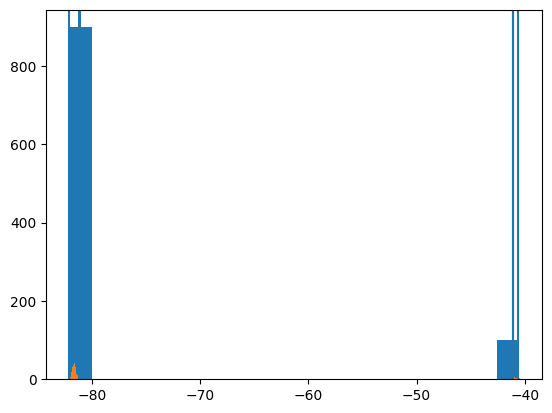

In [37]:
bin_count_edges = plt.hist(Es, bins=20)
bin_count_edges = plt.hist(predEs, bins=2000)
bins = [bin_count_edges[1][0]]
for i, _ in enumerate(bin_count_edges[0]):
    if _ == 0 and bin_count_edges[0][i-1] != 0:
        bins.append(bin_count_edges[1][i-1])
        plt.axvline(bins[-1])
bins.append(bin_count_edges[1][-1])
bins
    

In [38]:
Es

array([-81.55075956, -81.30681145, -81.47037743, -81.89984252,
       -81.64711092, -81.74610001, -81.83251956, -81.87199784,
       -81.90248115, -81.79867404, -81.48244884, -81.8797357 ,
       -82.01667354, -81.62111512, -81.79396587, -81.47189455,
       -40.80210687, -40.80151209, -81.63411231, -81.32612223,
       -81.57032455, -81.62151333, -81.79867404, -81.70341155,
       -81.6704584 , -81.53730664, -81.85760985, -81.88040948,
       -81.96476853, -81.43478249, -81.57003889, -81.65507673,
       -40.87128875, -81.39459663, -81.45462021, -81.79027484,
       -81.87127391, -81.8124061 , -81.71324569, -81.74873905,
       -81.83797686, -81.98254061, -81.59961282, -81.52334676,
       -81.80056387, -81.36611126, -40.67168915, -81.58960444,
       -81.34690255, -81.83251956, -81.52334676, -40.80210687,
       -81.59262338, -81.7819619 , -81.7770054 , -81.71498314,
       -81.63428236, -81.58291074, -40.86114799, -81.70717624,
       -81.6652346 , -81.70211757, -81.61660758, -81.71

[np.float64(-82.18224334716797), np.float64(-82.16138458251953), np.float64(-81.20205688476562), np.float64(-81.11863708496094), np.float64(-41.077030181884766), np.float64(-41.03532028198242), np.float64(-40.59736633300781), np.float64(-40.47223663330078)]


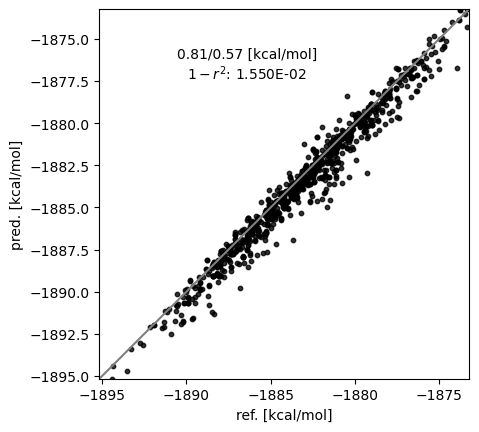

[np.float64(-82.18224334716797), np.float64(-82.16138458251953), np.float64(-81.20205688476562), np.float64(-81.11863708496094), np.float64(-41.077030181884766), np.float64(-41.03532028198242), np.float64(-40.59736633300781), np.float64(-40.47223663330078)]


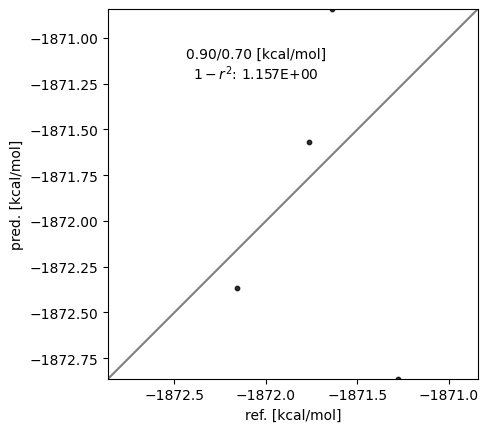

[np.float64(-82.18224334716797), np.float64(-82.16138458251953), np.float64(-81.20205688476562), np.float64(-81.11863708496094), np.float64(-41.077030181884766), np.float64(-41.03532028198242), np.float64(-40.59736633300781), np.float64(-40.47223663330078)]


/pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/physnetjax/analysis/analysis.py:25: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  slope, intercept, r_value, p_value, std_err = linregress(x, y)


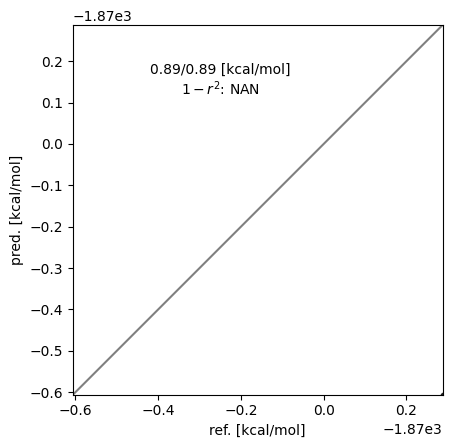

[np.float64(-82.18224334716797), np.float64(-82.16138458251953), np.float64(-81.20205688476562), np.float64(-81.11863708496094), np.float64(-41.077030181884766), np.float64(-41.03532028198242), np.float64(-40.59736633300781), np.float64(-40.47223663330078)]


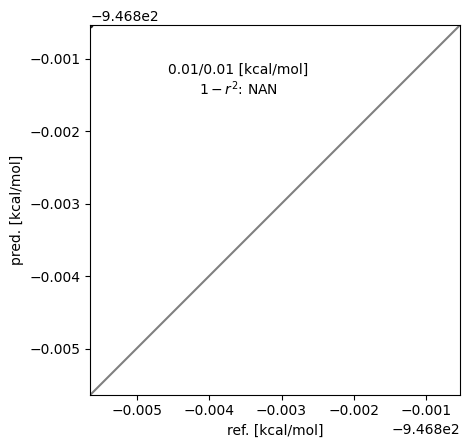

[np.float64(-82.18224334716797), np.float64(-82.16138458251953), np.float64(-81.20205688476562), np.float64(-81.11863708496094), np.float64(-41.077030181884766), np.float64(-41.03532028198242), np.float64(-40.59736633300781), np.float64(-40.47223663330078)]


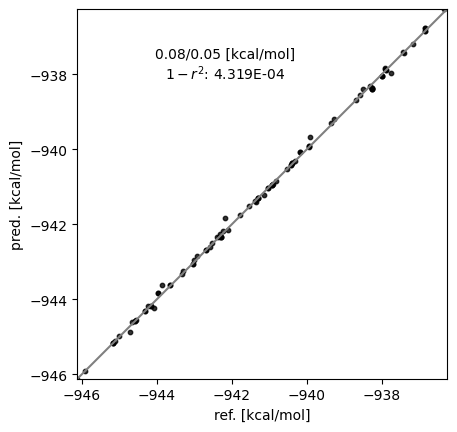

[np.float64(-82.18224334716797), np.float64(-82.16138458251953), np.float64(-81.20205688476562), np.float64(-81.11863708496094), np.float64(-41.077030181884766), np.float64(-41.03532028198242), np.float64(-40.59736633300781), np.float64(-40.47223663330078)]


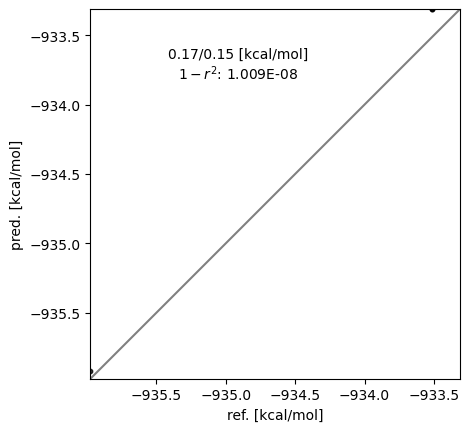

In [39]:
for i in range(len(bins)-1):
    monomers_idx = (Es < bins[1+i]) * (Es > bins[i])
    if np.sum(monomers_idx) != 0:
        # dimers_idx = Es < bins[1]
        print(bins)
        ax = plt.gca()
        plot(Es[monomers_idx]/ase_kcalmol, predEs[monomers_idx]/ase_kcalmol, ax, units="kcal/mol", _property="", kde=False, s=10, diag=True)
        # plt.xlim(bins[i], bins[i+1])
        # plt.ylim(bins[i], bins[i+1])
        plt.show()
    plt.show()
    # ax = plt.gca()
    # plot(Es[dimers_idx]/ase_kcalmol, predEs[dimers_idx]/ase_kcalmol, ax, units="kcal/mol", _property="", kde=False, s=1, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

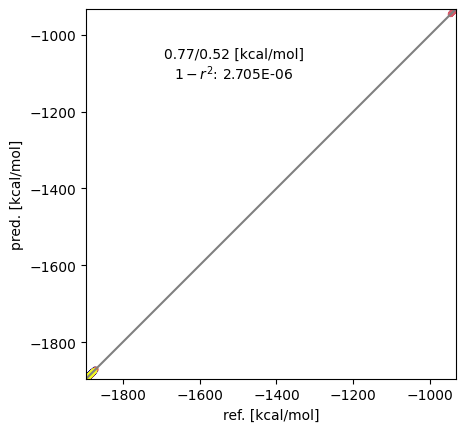

In [41]:
ax = plt.gca()
plot(Es/ase_kcalmol, predEs/ase_kcalmol, ax, units="kcal/mol", _property="", kde=True, s=10, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

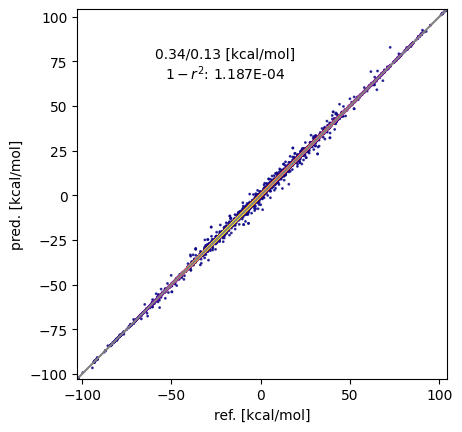

In [42]:
ax = plt.gca()
plot(Fs/ase_kcalmol, predFs/ase_kcalmol, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_680703/2792862587.py:2: SyntaxWarning: invalid escape sequence '\A'
  plot(Ds/ase_kcalmol, predDs/ase_kcalmol, ax, units="e $\AA$", _property="", kde=True, s=1, diag=True)


<Axes: xlabel='ref. [e $\\AA$]', ylabel='pred. [e $\\AA$]'>

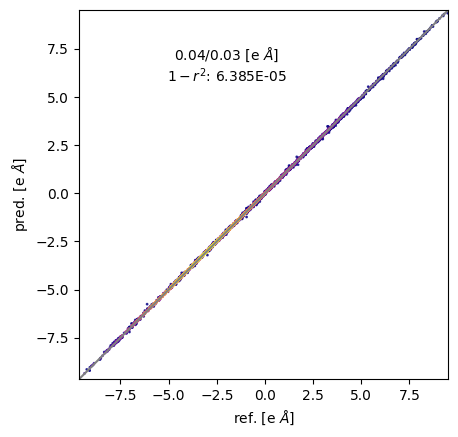

In [43]:
ax = plt.gca()
plot(Ds/ase_kcalmol, predDs/ase_kcalmol, ax, units="e $\AA$", _property="", kde=True, s=1, diag=True)

# Calculator

In [44]:
# !conda install pint
from mmml.pycharmmInterface import import_pycharmm
import pycharmm
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters

/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
/pchem-data/meuwly/boittier/home/mmml/mmml/data/par_all36_cgenff.prm
CHARMM_HOME /pchem-data/meuwly/boittier/home/mmml/setup/charmm
CHARMM_LIB_DIR /pchem-data/meuwly/boittier/home/mmml/setup/charmm
  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE 

In [45]:
?CutoffParameters

Init signature:
CutoffParameters(
    ml_cutoff: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
)
Docstring:      Parameters for ML and MM cutoffs and switching functions
Init docstring:
Args:
    ml_cutoff: Distance where ML potential is cut off
    mm_switch_on: Distance where MM potential starts switching on
    mm_cutoff: Final cutoff for MM potential
File:           ~/mmml/mmml/pycharmmInterface/cutoffs.py
Type:           type
Subclasses:     

In [46]:
ATOMS_PER_MONOMER = 10
N_MONOMERS = 2

In [47]:
?setup_calculator

Signature:
setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS: 'int' = 2,
    ml_cutoff_distance: 'float' = 2.0,
    mm_switch_on: 'float' = 5.0,
    mm_cutoff: 'float' = 1.0,
    doML: 'bool' = True,
    doMM: 'bool' = True,
    doML_dimer: 'bool' = True,
    debug: 'bool' = False,
    ep_scale=None,
    sig_scale=None,
    model_restart_path=None,
    MAX_ATOMS_PER_SYSTEM: 'int' = 20,
    ml_energy_conversion_factor: 'float' = 1.0,
    ml_force_conversion_factor: 'float' = 1.0,
    cell=False,
    verbose: 'bool' = False,
    ml_reorder_indices=None,
    at_codes_override=None,
)
Docstring: <no docstring>
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [48]:
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS,
    ml_cutoff_distance  = 0.01,
    mm_switch_on = 8.0,
    mm_cutoff  = 5.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug  = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = RESTART,
    MAX_ATOMS_PER_SYSTEM = 20,
)

[setup_calculator] Cutoff inputs -> ml_cutoff_distance=0.0100, mm_switch_on=8.0000, mm_cutoff=5.0000
[setup_calculator] CutoffParameters stored -> ml_cutoff=0.0100, mm_switch_on=8.0000, mm_cutoff=5.0000
0 1
len(dimer_perms) 1
dict_keys(['opt_state', 'params', 'step'])


/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_d… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl  ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━┩
│ True  │ 12.0  │ False │ False │ 128   │ 40    │ 1      │ 3     │ 20    │ 64     │ 3     │ 0      │ True  │ True │
└───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴───────┴────────┴───────┴────────┴───────┴──────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/e… │ epoch-3013 │ 3013  │ Array gpu:0 0.054 │ 2025-12-10 10:08:49.747151 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

In [49]:
from ase.visualize.plot import plot_atoms
from mmml.pycharmmInterface import import_pycharmm
from mmml.pycharmmInterface.import_pycharmm import  *

In [50]:
from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, reset_block_no_internal
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

CHARMM_HOME:  /pchem-data/meuwly/boittier/home/mmml/setup/charmm
CHARMM_LIB_DIR:  /pchem-data/meuwly/boittier/home/mmml/setup/charmm
/pchem-data/meuwly/boittier/home/mmml/setup/charmm
/pchem-data/meuwly/boittier/home/mmml/setup/charmm
['O', 'H', 'H']
['O', 'H', 'H']
[8, 1, 1]
['C', 'H', 'H', 'O', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'H']
['C', 'H', 'H', 'O', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'H']
[6, 1, 1, 8, 1, 6, 1, 1, 6, 1, 1, 6, 1, 1, 6, 1, 1, 6, 1, 1, 6, 1, 1, 6, 1, 1, 1]


In [51]:
CLEAR_CHARMM()
reset_block()
reset_block_no_internal()
reset_block()
reset_block()
reset_block_no_internal()
reset_block()

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interac

In [52]:
train_data, valid_data = prepare_datasets(data_key, 10500, 10500, [ "/pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz"], natoms=20)
valid_batches = prepare_batches_jit(data_key, valid_data, 1, num_atoms = 20)
train_batches = prepare_batches_jit(data_key, train_data, 1, num_atoms = 20)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [53]:
setupBox.initialize_psf("ACO", 2, 30, None)

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>    

In [54]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [55]:
energy.show()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   5 found   1200 exclusions and    600 interactions(1-4)
 <MAKGRP> found      0 group exclusions.
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0     -0.00000      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------


In [56]:
R = valid_batches[0]["R"]
Z = valid_batches[0]["Z"]
R,Z

(array([[-2.08 , -1.078, -6.721],
        [-1.95 ,  0.34 , -6.189],
        [-3.408, -1.718, -6.691],
        [-1.245, -1.674, -7.385],
        [-4.26 , -1.099, -6.813],
        [-3.541, -2.471, -5.843],
        [-3.45 , -2.432, -7.473],
        [-1.021,  0.419, -5.571],
        [-2.902,  0.607, -5.667],
        [-1.795,  1.06 , -7.068],
        [-0.714, -3.449, -2.642],
        [-0.504, -2.28 , -3.555],
        [-1.473, -4.567, -3.209],
        [-0.361, -3.486, -1.491],
        [-2.433, -4.227, -3.736],
        [-1.786, -5.336, -2.528],
        [-0.792, -5.109, -3.864],
        [ 0.538, -2.059, -3.396],
        [-1.157, -1.423, -3.239],
        [-0.758, -2.525, -4.579]]),
 array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]))

In [57]:
ase_atoms = ase.Atoms(Z, R)

In [58]:
FACTOR = 1/(ase.units.kcal/ase.units.mol)
calcs = calculator_factory(atomic_numbers=Z , atomic_positions=R , n_monomers=2,
                           # energy_conversion_factor=FACTOR, force_conversion_factor=FACTOR, 
                           debug=False
                          )

In [59]:
ase_atoms.calc = calcs[0]

In [60]:
ase_atoms.get_potential_energy()

  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>    500 atoms have been selected out of    500
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 

Array gpu:0 -81.453

In [61]:
calculator_factory?

Signature:
calculator_factory(
    atomic_numbers: 'Array',
    atomic_positions: 'Array',
    n_monomers: 'int',
    cutoff_params: 'CutoffParameters' = None,
    doML: 'bool' = True,
    doMM: 'bool' = True,
    doML_dimer: 'bool' = True,
    backprop: 'bool' = False,
    debug: 'bool' = False,
    energy_conversion_factor: 'float' = 1.0,
    force_conversion_factor: 'float' = 1.0,
    verbose: 'bool' = None,
) -> 'Tuple[AseDimerCalculator, Callable]'
Docstring:
Factory function to create calculator instances

Args:
    verbose: If True, store full ModelOutput breakdown in results.
             If None, defaults to debug value.
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [62]:
pycharmm_quiet()
pycharmm_verbose()

  
 CHARMM>     PRNLev 0
  
 CHARMM>    WRNLev 5
  


In [63]:
fix_idxs = np.array(range(20))
_fix_idxs = np.array(range(20))
fix_idxs[0] = _fix_idxs[3]
fix_idxs[3] = _fix_idxs[0]
fix_idxs[10] = _fix_idxs[13]
fix_idxs[13] = _fix_idxs[10]
batch_index = 0

In [64]:
test_R = valid_batches[batch_index]["R"][:20][fix_idxs]

In [65]:
test_Z = valid_batches[batch_index]["Z"][:20]
test_Z, test_Z[fix_idxs]

(array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]),
 array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1]))

In [66]:
model.natoms = 20
model

EF(
    # attributes
    features = 128
    max_degree = 1
    num_iterations = 3
    num_basis_functions = 64
    cutoff = 12.0
    max_atomic_number = 40
    charges = True
    natoms = 20
    total_charge = 0
    n_res = 3
    zbl = True
    debug = False
    efa = False
    use_energy_bias = True
)

In [67]:
ref_physnet_atoms = ase.Atoms(test_Z[fix_idxs], test_R)
ref_physnet_atoms.calc = get_ase_calc(params, model, ref_physnet_atoms, {"energy": 1, "forces": 1}, ['energy', 'forces'])

['energy', 'forces']


In [68]:
ref_physnet_atoms.get_potential_energy()

Array gpu:0 -81.626

In [69]:
ref_physnet_F = ref_physnet_atoms.get_forces().flatten()

In [70]:
ref_e = valid_batches[batch_index]["E"][0][0]
ref_e

np.float64(-81.58712660232891)

In [71]:
ref_f = valid_batches[batch_index]["F"][:20]
refF = ref_f.flatten()

In [72]:
ase_atoms.set_positions(test_R)

In [73]:
ase_atoms.set_atomic_numbers(ref_physnet_atoms.get_atomic_numbers())

In [74]:
ase_atoms.get_potential_energy()

Array gpu:0 -81.448

In [75]:
mF = np.array(ase_atoms.get_forces()).flatten()

In [76]:
ks = [
 'dH',
 'energy',
 'forces',
 'internal_E',
 'internal_F',
 'ml_2b_E',
 'ml_2b_F',
 'mm_E',
 'mm_F']
di = {}
for k in ks:
    di[k] = dict(ase_atoms.calc.results)["out"].__getattribute__(k).flatten()

In [77]:
dir(dict(ase_atoms.calc.results)["out"])
di

{'dH': Array[1] gpu:0 [0.],
 'energy': Array[1] gpu:0 [-81.448],
 'forces': Array[60] x∈[-2.158, 2.043] μ=0.085 σ=0.887 gpu:0,
 'internal_E': Array[1] gpu:0 [-81.533],
 'internal_F': Array[60] x∈[-2.243, 1.958] μ=-5.816e-05 σ=0.887 gpu:0,
 'ml_2b_E': Array[1] gpu:0 [0.],
 'ml_2b_F': Array[60] all_zeros gpu:0,
 'mm_E': Array[1] gpu:0 [0.085],
 'mm_F': Array[60] x∈[-0.004, 0.004] μ=0. σ=0.003 gpu:0}

In [78]:
view_atoms(ref_physnet_atoms)

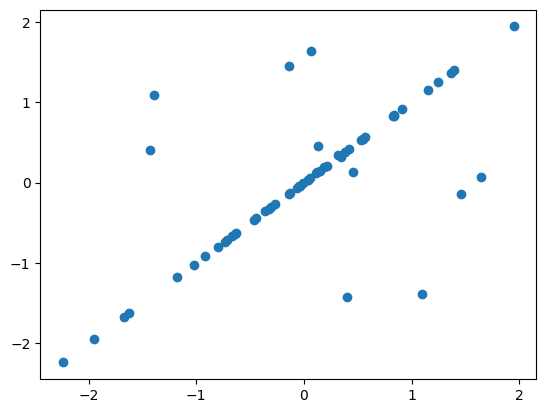

In [79]:
plt.scatter(refF, ref_physnet_F)

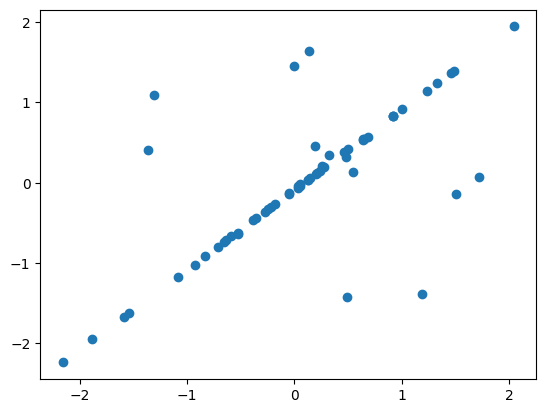

In [80]:
plt.scatter(mF,refF)

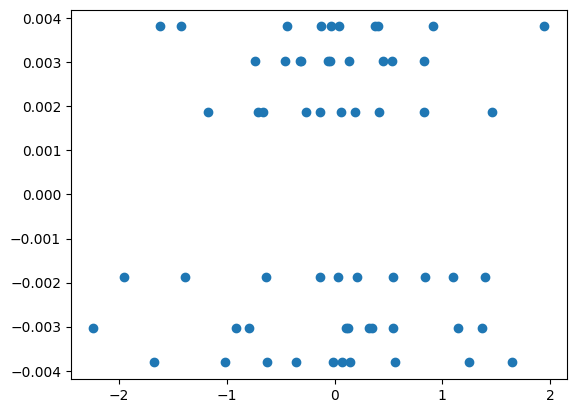

In [81]:
plt.scatter(refF,di["mm_F"])

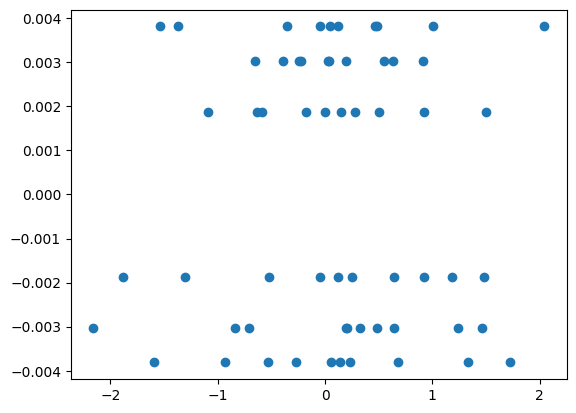

In [82]:
plt.scatter(mF,di["mm_F"])

In [83]:
np.array(dict(ase_atoms.calc.results)["out"].internal_E)*FACTOR + dict(ase_atoms.calc.results)["out"].mm_E

Array gpu:0 -1.880e+03

In [84]:
np.array(dict(ase_atoms.calc.results)["out"].internal_F)

array([[ 1.4177563 ,  0.40020275,  0.40049207],
       [ 0.41499695,  0.55955607, -0.44312474],
       [-0.72087765, -2.2434092 ,  1.9581878 ],
       [-0.08926683,  0.23991296, -1.4514874 ],
       [-1.172917  ,  1.1507642 ,  0.3762574 ],
       [ 0.06179023,  1.3731326 , -0.13563518],
       [ 0.19089392, -0.7960496 , -1.6269274 ],
       [-0.6751578 ,  0.11296225, -0.03595544],
       [ 0.83726853,  0.1223404 ,  0.03721514],
       [-0.26507437, -0.91933703,  0.92012095],
       [ 1.1015289 ,  0.46120232,  1.6393225 ],
       [-0.6082336 ,  0.5518278 ,  0.5994086 ],
       [-1.9667618 , -0.7374488 , -1.6741984 ],
       [-1.3933172 ,  0.10928744,  0.05544245],
       [ 1.4002964 , -0.32638717,  0.15052891],
       [-0.13200086, -0.30733353,  1.2471311 ],
       [ 0.03848465, -0.05172384, -1.0156194 ],
       [ 0.83542836,  0.82953686, -0.3552208 ],
       [ 0.55518574, -0.47542965, -0.03307909],
       [ 0.16920051, -0.05520575, -0.61397314]], dtype=float32)

In [86]:
view_atoms(ase_atoms)


In [ ]:
setupRes.generate_residue("ACO ACO")
ic.build()
coor.show()

In [ ]:
test_R

In [ ]:
xyz = pd.DataFrame(test_R, columns=["x", "y", "z"])
coor.set_positions(xyz)

In [ ]:
# energy.show()

In [ ]:
# coor.show()

In [ ]:
nbonds = """!#########################################
! Bonded/Non-bonded Options & Constraints
!#########################################

! Non-bonding parameters
nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
vswitch NBXMOD 3 -
inbfrq -1 imgfrq -1
"""
pycharmm.lingo.charmm_script(nbonds)

In [ ]:
pycharmm_quiet()
energy.show()

In [ ]:
energy.get_term_by_name("VDW")

In [ ]:
energy.get_term_by_name("ELEC")

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
pycharmm_verbose()
energy.show()

In [ ]:
CLEAR_CHARMM()

In [ ]:
atoms = setupRes.main("ACO")

In [ ]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()


In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
energy.show()

In [ ]:
energy.get_term_by_name("VDW")

In [ ]:
pycharmm.lingo.get_energy_value("ENER")

# Example: packmol for a dimer system

In [ ]:
run_packmol(20, 30)

In [ ]:
def CLEAR_CHARMM():
    s = """DELETE ATOM SELE ALL END"""
    pycharmm.lingo.charmm_script(s)
    s = """DELETE PSF SELE ALL END"""
    pycharmm.lingo.charmm_script(s)

CLEAR_CHARMM()

In [ ]:
reset_block()
reset_block_no_internal()
reset_block()
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
# pycharmm_verbose()

In [ ]:
# pycharmm.lingo.charmm_script(nbonds)

# #equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
# minimize.run_abnr(nstep=1000, tolenr=1e-1, tolgrd=1e-1)
# #equivalent CHARMM scripting command: energy
# energy.show()

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
ase_atoms.set_positions(coor.get_positions())
view_atoms(ase_atoms)

In [ ]:
cs

In [ ]:
ase_atoms.get_potential_energy()

In [ ]:
ase_atoms.calc.results #["out"]

In [ ]:
ase_atoms.calc.results["out"].mm_E

In [ ]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms).run(fmax=0.001)

In [ ]:
view_atoms(ase_atoms)

In [ ]:
# Parameters.
temperature = 10
timestep_fs = 0.1
num_steps = 300

# Draw initial momenta.
MaxwellBoltzmannDistribution(ase_atoms, temperature_K=temperature)
Stationary(ase_atoms)  # Remove center of mass translation.
ZeroRotation(ase_atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(ase_atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(ase_atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = ase_atoms.get_positions()
  potential_energy[i] = ase_atoms.get_potential_energy()
  kinetic_energy[i] = ase_atoms.get_kinetic_energy()
  total_energy[i] = ase_atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

In [ ]:
# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# xyz = io.StringIO()
# ase_io.write(xyz, ase_atoms, format='xyz')
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': 'forward', 'interval': 0.1})
# view.show() 

In [ ]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [ ]:
view_atoms(ase_atoms)